# Day 3
## Optimizers
- implement SGD, Momentum (with Nesterov lookup), AdamW

### SGD
At each training step, given parameters $\theta$ (weights), gradient $g = \nabla_\theta L(\theta)$ and a learning rate $\eta$, take: 
$$ \theta \leftarrow \theta - \eta g $$


In [9]:
from optimizers import SGD

### Momentum 
Momentum beats on problems with strong curvature anisotropy (ravines/ill conditioning) or saddle-heavy landscapes.

At each training step, compute the effective gradient as: 
$$v = \beta v + (1- \epsilon) \nabla_\theta L$$ 
$$ g_\text{eff} = v$$ 
if momentum or 
$$g_\text{eff} = \nabla_\theta L + \beta v$$
if Nesterov momentum (lookahead). Again apply 

$$ \theta = \theta - \eta g_\text{eff}$$


In [16]:
from optimizers import Momentum

### AdamW

Adam uses a momentum update for each parameter $i$. 
$$ 
m_i = \beta_1 m_i + (1-\beta_1) g
$$

It also uses RMSProp; exponential moving average for squared gradients. 
$$ 
v_i = \beta_2 v_i + (1 - \beta_2) g^2
$$

The algorithm keeps track of the number of steps it took - $t$. Bias correction: 
$$ 
\hat{m} = m_i / (1 - \beta_1^t) \\ 
\hat{v} = v_i / (1-\beta_2^t)
$$

Update
$$
\theta -= \eta \hat{m}/(\sqrt{\hat{v}}+\epsilon)  + (\text{weight decay}) \cdot \theta
$$


In [11]:
from optimizers import AdamW

## Comparison

In [32]:
import numpy as np

def random_orthogonal_matrix(n: int, seed:int | None = None) -> np.ndarray:
    """Haar-random orthogonal matrix via QR decomposition.
    Ensure positive diagonal in R to fix sign ambiguity.

    Args:
        n (int): dimension of the matrix
        seed (int | None, optional): RNG seed. Defaults to None.
    
    Returns:
        np.ndarray: random orthogonal matrix of shape (n, n)

    """  # noqa: D205
    rng = np.random.default_rng(seed)
    gaussian = rng.standard_normal((n, n))
    Q, R = np.linalg.qr(gaussian)

    signs = np.sign(np.diag(R))
    signs[signs == 0] = 1  # Handle zero diagonal elements
    Q = Q * signs 
    return Q


def make_rot_quadratic(d = 100, 
                       kappa = 1e4, 
                       seed: int | None = 0):
    """Return (f, grad, H) for f(w) = 0.5 w^T H w, where
    H = Q^T diag(lambdas) Q with cond(H) = kappa.

    Args:
        d (int, optional): dimension. Defaults to 100.
        kappa (_type_, optional): condition number: largest/smallest egv. Defaults to 1e4.
        seed (int | None, optional): RNG seed. Defaults to 0.

    Returns:
        f (callable): function to evaluate
        grad (callable): gradient of the function
        H (np.ndarray): Hessian matrix

    """  # noqa: D205
    Q = random_orthogonal_matrix(d, seed)
    lambdas = np.linspace(1.0, kappa, d)
    H = Q.T @ np.diag(lambdas) @ Q 

    def f(w:np.ndarray) -> float:
        """Quadratic function."""
        return 0.5 * w.T @ H @ w

    def grad(w:np.ndarray) -> np.ndarray:
        """Gradient of the quadratic function."""
        w = np.asarray(w)
        return H @ w

    return f, grad, H


### Visualisation

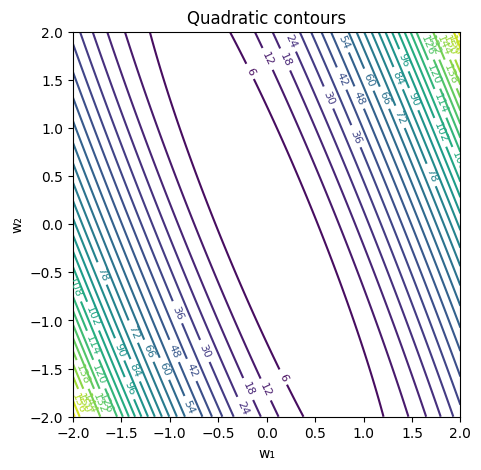

In [35]:
import matplotlib.pyplot as plt

f, grad, H = make_rot_quadratic(d=2, kappa=50, seed=42)

# Grid
x = np.linspace(-2, 2, 200)
y = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        w = np.array([X[i, j], Y[i, j]])
        Z[i, j] = f(w)

plt.figure(figsize=(5,5))
cs = plt.contour(X, Y, Z, levels=30, cmap="viridis")
plt.clabel(cs, inline=1, fontsize=8)
plt.xlabel("w₁"); plt.ylabel("w₂")
plt.title("Quadratic contours")
plt.show()

### Synth Dataset + decision boundary

Text(0.5, 1.0, 'Synthetic Moons Dataset')

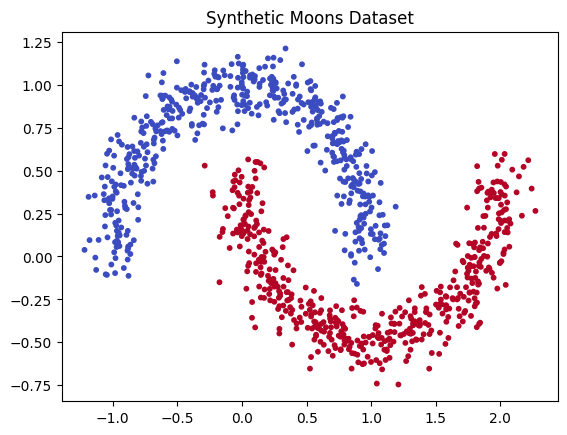

In [14]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=1000, noise=0.1, random_state=42)
fig, ax = plt.subplots()
ax.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='coolwarm', s=10)
ax.set_title("Synthetic Moons Dataset")

In [15]:
MLP_moons = MLP(D=2, H=10, C=2, seed=42)
ds_moons = ArrayDataset(X_moons, y_moons)
loader_moons = Dataloader(ds_moons, batch_size=32, shuffle=True, drop_last=True, seed=42)

NameError: name 'MLP' is not defined

In [ ]:
num_classes = 2

def to_one_hot(y, num_classes):
    # y: (B,) integer labels
    oh = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    oh[np.arange(y.shape[0]), y.astype(int)] = 1.0
    return oh


for epoch in range(5000):
    loader_moons.set_epoch(epoch)

    epoch_loss = 0.0
    n_examples = 0
    #print(f"\n[Epoch {epoch}]")


    for xb, yb in loader_moons:
        # Ensure shapes/dtypes are what your MLP expects
        if yb.ndim == 1 or yb.shape[-1] == 1:        # likely indices
            yb_oh = to_one_hot(yb.reshape(-1), num_classes)
        else:
            yb_oh = yb                                # already one-hot
        loss = MLP_moons.sgd_step(xb, yb_oh, lr=0.01, l2=0.0)  # make sure loss is mean over the batch
        batch_size = xb.shape[0]
        epoch_loss += loss * batch_size                # accumulate by sample count
        n_examples += batch_size

    #print(f"[Epoch {epoch}] loss={epoch_loss / n_examples:.4f}")
    #    print(f"Loss: {loss:.4f}")

print(f"Final loss: {epoch_loss / n_examples:.4f}")


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y, ax=None, padding=0.5, resolution=400, cmap="coolwarm"):
    """
    Plots decision regions for a 2D dataset.
    - model must implement .predict(X) -> (N,) class indices
      (or .predict_proba(X) returning probs; we’ll argmax them).
    - X: (N, 2) features
    - y: (N,) class indices OR (N, C) one-hot
    """
    X = np.asarray(X)
    assert X.shape[1] == 2, "This helper expects 2D inputs."
    if y.ndim == 2:
        y_plot = y.argmax(axis=1)
    else:
        y_plot = y

    # grid limits
    x_min, x_max = X[:,0].min() - padding, X[:,0].max() + padding
    y_min, y_max = X[:,1].min() - padding, X[:,1].max() + padding

    # meshgrid
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # predict on grid
    try:
        Z = model.predict(grid)                 # preferred (already argmaxed)
    except Exception:
        Z = model.predict_proba(grid).argmax(1) # fallback if only proba exists
    Z = Z.reshape(xx.shape)

    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))

    # background decision regions
    im = ax.contourf(xx, yy, Z, levels=np.unique(Z).size, alpha=0.3, antialiased=True)

    # decision boundary lines (optional, looks nice)
    ax.contour(xx, yy, Z, levels=np.unique(Z), linewidths=1.0, colors='k', alpha=0.4)

    # scatter training data
    scatter = ax.scatter(X[:,0], X[:,1], c=y_plot, s=25, edgecolor='k', linewidth=0.4, cmap=cmap)

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_title("Decision boundary")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # legend-like handles for classes (optional)
    # If


NameError: name 'MLP_moons' is not defined

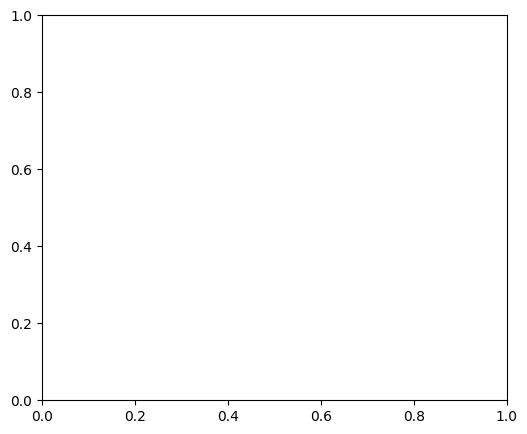

In [4]:
fig, ax = plt.subplots(figsize=(6,5))
plot_decision_boundary(MLP_moons, X_moons, y_moons, ax=ax, padding=0.5, resolution=400)
plt.show()